### Hansen(1985): Continuous Dynamic Programming


#### Translated from Eva Carceles-Poveda's MATLAB codes

In [1]:
# Importing packages
import numpy as np
import matplotlib.pyplot as plt
# The magic command below causes the resulting plots to be stored in the notebook document
# Only works in IPython Notebooks and not in regular Python files
%matplotlib inline

# This is used for the root_scalar and fminbound functions
from scipy.optimize import root_scalar, fminbound

# needed for compact printing of numpy arrays
# use precision to set the number of decimal digits to display
# use suppress=True to show values in full decimals instead of using scientific notation
np.set_printoptions(suppress=True,precision=4,linewidth=np.inf)

#### The function markov_approx is copied below.

In [2]:
# markovapprox: approximates a continuous AR(1) process with a Markov chain
# Eva Carceles-Poveda's version. You can use this function, Floden's tauchen function, or Sargent's tauchen function.

from scipy.stats import norm
def markov_approx(rho, sigma, m, N):
    """ Syntax: [Tran,s,p,arho,asigma]=markovapprox(rho,sigma,m,N)
    
    This function approximates a first-order autoregressive process 
    with persistence rho and innovation standard deviation sigma with 
    an N state Markov chain; m determines the width of the discretized 
    state space, Tauchen uses m=3, with ymax=m*vary,ymin=-m*vary, where 
    ymax and ymin are the two boundary points, Tran is the transition 
    matrix of the Markov chain, s is the discretized state space, p is 
    the chain stationary distribution, arho is the theoretical first 
    order autoregression coefficient for the Markov chain, asigma is 
    the theoretical standard deviation for the Markov chain.
    
    Translated from Eva Carceles-Poveda 2003 MATLAB code
    """
    
    # Discretize the state space
    stvy = np.sqrt(sigma**2/(1-rho**2))   # standard deviation of y(t)
    ymax = m*stvy                         # upper boundary of state space
    ymin = -ymax                          # lower boundary of state space
    w = (ymax-ymin)/(N-1)                 # distance between points
    s = w * np.arange(ymin/w, ymax/w+1)   # the discretized state space        
    
    
    # Calculate the transition matrix
    Tran = np.zeros((N,N))
    for j in np.arange(0,N):
        for k in np.arange(1,N-1):
            Tran[j,k] = norm.cdf(s[k]-rho*s[j]+w/2,0,sigma) - norm.cdf(s[k]-rho*s[j]-w/2,0,sigma);
            
        Tran[j,0] = norm.cdf(s[0]-rho*s[j]+w/2,0,sigma);
        Tran[j,N-1] = 1 - norm.cdf(s[N-1]-rho*s[j]-w/2,0,sigma);
        
    # Check that Tran is well specified
    if not np.all(np.isclose(np.sum(Tran.T, axis=0), np.squeeze(np.ones((1,N))))):
        # find rows not adding up to one
        str = (np.absolute(np.sum(Tran.T, axis=0))-np.squeeze(np.ones((1,N)))<1e-14).nonzero()          
        print('error in transition matrix')
        print('rows', str[0],' do not sum to one')
    
    
    # Calculate the invariant distribution of Markov chain
    Trans = Tran.T
    p = (1/N)*np.ones((N,1)) # initial distribution of states
    test = 1;
    while test > 1e-8:
        p1 = np.matmul(Trans,p)
        test=np.max(np.abs(p1-p))
        p = p1
    
    
    meanm = np.matmul(s,p)            # mean of invariant distribution of chain
    varm = np.matmul((s-meanm)**2,p)  #variance of invariant distribution of chain  
    midaut1 = np.matmul((s-meanm)[:, np.newaxis],(s-meanm)[np.newaxis, :]) # cross product of deviation from mean of yt and yt-1                    
    probmat = np.matmul(p,np.ones((1,N)))     # each column is invariant distribution   
    midaut2 = Tran*probmat*midaut1 # product of the first two terms is joint distribution of (Yt-1,Yt)                                    
    autcov1 = np.sum(midaut2)    #  first-order auto-covariance
    
    
    arho = autcov1/varm           # theoretical first order autoregression coefficient
    asigma = np.sqrt(varm)           # theoretical standard deviation
    
    return Tran, s, p, arho, asigma

#### The Hodrick-Prescott filter function is copied below

In [3]:
def hp1(y,w):

    """ Syntax: yhp, ytr = hp1(y, w)
    
    This function computes the filtered series of y, using
    a smoothing parameter w. 
    
    The code is from I. Izvorski.
    """

    t, s = y.shape
    
    if t < s:
        y = y.T

    a = 6*w + 1
    b = -4*w
    c = w
    d = np.array([[c,b,a]])
    d = np.ones((t,1))*d
    m = np.diag(d[:,2])+np.diag(d[0:-1,1],1)+np.diag(d[0:-1,1],-1)
    m = m+np.diag(d[0:-2,0],2)+np.diag(d[0:-2,0],-2)

    m[0,0] = 1+w;       m[0,1] = -2*w;
    m[1,0] = -2*w;      m[1,1] = 5*w+1;
    m[-2,-2] = 5*w+1;   m[-2,-1] = -2*w;
    m[-1,-2] = -2*w;    m[-1,-1] = 1+w;
    
    ytr = np.matmul(np.linalg.inv(m),y)
    yhp = y-ytr

    return yhp, ytr

### Functions needed to solve the problem

In [4]:
def lfoc(x,zt,ki,kpr,alf,a,delta):
    c = (1-alf) * zt*ki**alf*x**(-alf)*(1-x)/a
    F = c+kpr-(1-delta)*ki-zt*ki**alf*x**(1-alf)
    return F

In [5]:
def maxinter(kpr, alf, k, beta, zt, t, i, a, delta, lmin, lmax, V0, Tran):

    pos = np.abs(kpr-k).argmin()
    
    global l, c
    
    l = root_scalar(lfoc, args=(zt,k[i],kpr,alf,a,delta), bracket=[lmin,lmax]).root

    if l < 0:
        l = lmin

    if l > 1:
        l = lmax

    c = (1-alf)*zt*k[i]**alf*l**(-alf)*(1-l)/a

    if k[pos] > kpr:
        weight = (k[pos]-kpr)/(k[pos]-k[pos-1])
        y = np.log(c) + a*np.log(1-l) + beta*np.matmul(weight*V0[pos-1,:] + (1-weight)*V0[pos,:],Tran[t,:])
    elif k[pos] == kpr:
        y = np.log(c) + a*np.log(1-l) + beta*np.matmul(V0[pos,:],Tran[t,:])
    else:
        weight = (kpr-k[pos])/(k[pos+1]-k[pos])
        y = np.log(c) + a*np.log(1-l) + beta*np.matmul(weight*V0[pos+1,:]+(1-weight)*V0[pos,:],Tran[t,:])
        
    y = -y

    return y

In [6]:
def llfoc(x,zt,ktime,kpr,alf,a,delta):
    c = (1-alf) * zt*ktime**alf*x**(-alf)*(1-x)/a
    F = c+kpr-(1-delta)*ktime-zt*ktime**alf*x**(1-alf)
    return F

In [7]:
def simulation(kpr, k, beta, time, m, a, V0, Tran, tind, zt, alf, ktime, lmin, lmax, delta):

    pos = np.abs(kpr-k).argmin()
    
    global l, c
    
    l = root_scalar(llfoc, args=(zt,ktime,kpr,alf,a,delta), bracket=[lmin,lmax]).root

    if l < 0:
        l = lmin

    if l > 1:
        l = lmax

    c = (1-alf)*zt*ktime**alf*l**(-alf)*(1-l)/a

    if k[pos] > kpr:
        weight = (k[pos]-kpr)/(k[pos]-k[pos-1])
        y = np.log(c) + a*np.log(1-l) + beta*np.matmul(weight*V0[pos-1,:] + (1-weight)*V0[pos,:],Tran[tind[m,time],:])
    elif k[pos] == kpr:
        y = np.log(c) + a*np.log(1-l) + beta*np.matmul(V0[pos,:],Tran[tind[m,time],:])
    else:
        weight = (kpr-k[pos])/(k[pos+1]-k[pos])
        y = np.log(c) + a*np.log(1-l) + beta*np.matmul(weight*V0[pos+1,:]+(1-weight)*V0[pos,:],Tran[tind[m,time],:])
        
    y = -y

    return y

In [8]:
# Model Parameters
alf = 0.36
beta = 0.99
a = 2
delta = 0.025
rho = 0.95
sigmae = 0.00712

# Algorithm Parameters
siyes = 1 # simulte model if equals to 1
tolv = 1e-3 # tolerance level
loadin = 0
loadsimuin = 1

In [9]:
# Discretize continuous shocks into Markov process
N = 7          # 7 state Markov chain
M = 3
zbar = 1       # unconditional mean of z
Tran, z, p, arho, asigma = markov_approx(rho,sigmae,M,N)
z = np.exp(z)

# Grid for the shock
lt = z.size
Pi = np.linalg.matrix_power(Tran, 10000)
Ez = 1

In [10]:
# Define Steady state variables
xx = (1-beta*(1-delta))/(beta*alf*Ez)
yy = ((1/beta+delta-1)/alf*(1+(1-alf)/a)-delta)*a/((1-alf)*Ez)
l_ss = xx/yy  # for this set of parameters, the steady state labor approxiamately equals to 1/3
k_ss = xx**(1/(alf-1))*l_ss
y_ss = Ez*k_ss**alf*l_ss**(1-alf)
i_ss = delta*k_ss
c_ss = y_ss-i_ss

In [11]:
# Define capital grid
kmin = 0.894*k_ss
kmax = 1.115*k_ss

lk = 200
gdk = (kmax-kmin)/(lk-1)
k = np.linspace(kmin,kmax,lk)

In [12]:
# Labor working hour
lmin = 1e-5
lmax = 1-lmin

# Initialization of the value function and policy functions
V0 = np.ones((lk,lt))
V1 = np.zeros((lk,lt))
kpr = np.zeros((lk,lt))
lpol = np.zeros((lk,lt))
polc = np.zeros((lk,lt))

# Compute the value functions and Policy Functions
iteration = 0

while np.abs(V1-V0).max(axis=0).max() > tolv:
    V0 = V1.copy()
    for t in np.arange(0,lt):
        for i in np.arange(0,lk):
            kpr[i,t]=fminbound(func=maxinter,x1=k[0],x2=min(z[t]*k[i]**alf+(1-delta)*k[i]-0.00001,k[lk-1]),\
                                        args=(alf, k, beta, z[t], t, i, a, delta, lmin, lmax, V0, Tran,),xtol=1e-04)
                                                             
            V1[i,t]=-maxinter(kpr[i,t],alf, k, beta, z[t], t, i, a, delta, lmin, lmax, V0, Tran)
            lpol[i,t] = l
            polc[i,t] = c
            
    iteration = iteration + 1
    print("iteration =", iteration, ", max(V1-V0) = ", np.abs((V1-V0)).max(axis=0).max())

del c, l

iteration = 1 , max(V1-V0) =  1.0114093525709067
iteration = 2 , max(V1-V0) =  0.997271579353245
iteration = 3 , max(V1-V0) =  0.9836053642244158
iteration = 4 , max(V1-V0) =  0.9703204851023082
iteration = 5 , max(V1-V0) =  0.9573898205233737
iteration = 6 , max(V1-V0) =  0.9447898437206517
iteration = 7 , max(V1-V0) =  0.9324998639056545
iteration = 8 , max(V1-V0) =  0.9205015603151923
iteration = 9 , max(V1-V0) =  0.9087786066262673
iteration = 10 , max(V1-V0) =  0.8973163620400051
iteration = 11 , max(V1-V0) =  0.8861016367574308
iteration = 12 , max(V1-V0) =  0.8751224828004833
iteration = 13 , max(V1-V0) =  0.8643680213025657
iteration = 14 , max(V1-V0) =  0.8538283000982982
iteration = 15 , max(V1-V0) =  0.8434941751315499
iteration = 16 , max(V1-V0) =  0.8333572112658274
iteration = 17 , max(V1-V0) =  0.82340959926381
iteration = 18 , max(V1-V0) =  0.8136440852667359
iteration = 19 , max(V1-V0) =  0.8040539112585492
iteration = 20 , max(V1-V0) =  0.7946327634163097
iteration = 

iteration = 164 , max(V1-V0) =  0.17842997630550883
iteration = 165 , max(V1-V0) =  0.1766441012471489
iteration = 166 , max(V1-V0) =  0.17487615825956482
iteration = 167 , max(V1-V0) =  0.1731259646260952
iteration = 168 , max(V1-V0) =  0.17139333961347347
iteration = 169 , max(V1-V0) =  0.16967810444498355
iteration = 170 , max(V1-V0) =  0.1679800822739992
iteration = 171 , max(V1-V0) =  0.16629909815807764
iteration = 172 , max(V1-V0) =  0.16463497903372115
iteration = 173 , max(V1-V0) =  0.1629875536918064
iteration = 174 , max(V1-V0) =  0.16135665275332656
iteration = 175 , max(V1-V0) =  0.15974210864573024
iteration = 176 , max(V1-V0) =  0.15814375557965832
iteration = 177 , max(V1-V0) =  0.15656142952622076
iteration = 178 , max(V1-V0) =  0.1549949681950693
iteration = 179 , max(V1-V0) =  0.1534442110117311
iteration = 180 , max(V1-V0) =  0.15190899909656252
iteration = 181 , max(V1-V0) =  0.1503891752436317
iteration = 182 , max(V1-V0) =  0.14888458390028347
iteration = 183 , m

iteration = 322 , max(V1-V0) =  0.036452259547957055
iteration = 323 , max(V1-V0) =  0.036087736167232265
iteration = 324 , max(V1-V0) =  0.03572685805734466
iteration = 325 , max(V1-V0) =  0.035369588763913384
iteration = 326 , max(V1-V0) =  0.035015892197080234
iteration = 327 , max(V1-V0) =  0.034665732627971124
iteration = 328 , max(V1-V0) =  0.03431907468514339
iteration = 329 , max(V1-V0) =  0.0339758833508057
iteration = 330 , max(V1-V0) =  0.03363612395756377
iteration = 331 , max(V1-V0) =  0.03329976218465447
iteration = 332 , max(V1-V0) =  0.032966764054677355
iteration = 333 , max(V1-V0) =  0.032637095929999305
iteration = 334 , max(V1-V0) =  0.032310724509514444
iteration = 335 , max(V1-V0) =  0.03198761682484985
iteration = 336 , max(V1-V0) =  0.03166774023787866
iteration = 337 , max(V1-V0) =  0.031351062436542065
iteration = 338 , max(V1-V0) =  0.03103755143204978
iteration = 339 , max(V1-V0) =  0.030727175555540498
iteration = 340 , max(V1-V0) =  0.030419903454941277
it

iteration = 478 , max(V1-V0) =  0.007600018774795103
iteration = 479 , max(V1-V0) =  0.007524018123433507
iteration = 480 , max(V1-V0) =  0.007448777331774181
iteration = 481 , max(V1-V0) =  0.0073742894305581785
iteration = 482 , max(V1-V0) =  0.007300546439822142
iteration = 483 , max(V1-V0) =  0.0072275423265324434
iteration = 484 , max(V1-V0) =  0.007155266439511365
iteration = 485 , max(V1-V0) =  0.0070837131670487
iteration = 486 , max(V1-V0) =  0.007012877147886343
iteration = 487 , max(V1-V0) =  0.0069427479126176195
iteration = 488 , max(V1-V0) =  0.006873319822972235
iteration = 489 , max(V1-V0) =  0.00680458649675586
iteration = 490 , max(V1-V0) =  0.006736541880883351
iteration = 491 , max(V1-V0) =  0.0066691759982830945
iteration = 492 , max(V1-V0) =  0.006602483627702327
iteration = 493 , max(V1-V0) =  0.006536459906087089
iteration = 494 , max(V1-V0) =  0.006471094843206515
iteration = 495 , max(V1-V0) =  0.006406384391340225
iteration = 496 , max(V1-V0) =  0.00634232008

iteration = 632 , max(V1-V0) =  0.0016167196939846917
iteration = 633 , max(V1-V0) =  0.0016005523687283585
iteration = 634 , max(V1-V0) =  0.0015845467475372743
iteration = 635 , max(V1-V0) =  0.0015687011998011258
iteration = 636 , max(V1-V0) =  0.0015530156229601744
iteration = 637 , max(V1-V0) =  0.001537485002700123
iteration = 638 , max(V1-V0) =  0.0015221095418382902
iteration = 639 , max(V1-V0) =  0.0015068895609431365
iteration = 640 , max(V1-V0) =  0.0014918202013376458
iteration = 641 , max(V1-V0) =  0.0014769013901343442
iteration = 642 , max(V1-V0) =  0.0014621322482781807
iteration = 643 , max(V1-V0) =  0.001447510828811005
iteration = 644 , max(V1-V0) =  0.00143303563922359
iteration = 645 , max(V1-V0) =  0.00141870671750155
iteration = 646 , max(V1-V0) =  0.0014045191863090167
iteration = 647 , max(V1-V0) =  0.0013904733861664909
iteration = 648 , max(V1-V0) =  0.001376568524520394
iteration = 649 , max(V1-V0) =  0.0013628027420651279
iteration = 650 , max(V1-V0) =  0.0

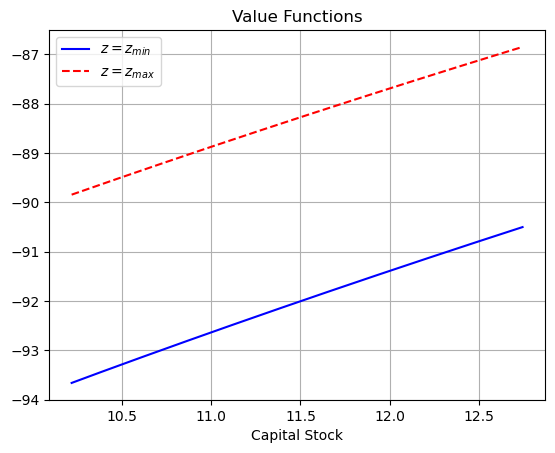

In [13]:
# Make plots of value and policy functions
fig1, ax1 = plt.subplots()
ax1.plot(k, V1[:,0], 'b', label = '$z=z_{min}$')
ax1.plot(k, V1[:,-1], 'r--', label = '$z=z_{max}$')

ax1.set(xlabel='Capital Stock', title='Value Functions')
ax1.grid()
ax1.legend()

fig1.savefig("Hansen_CDP_value.jpg", dpi=800)
plt.show()

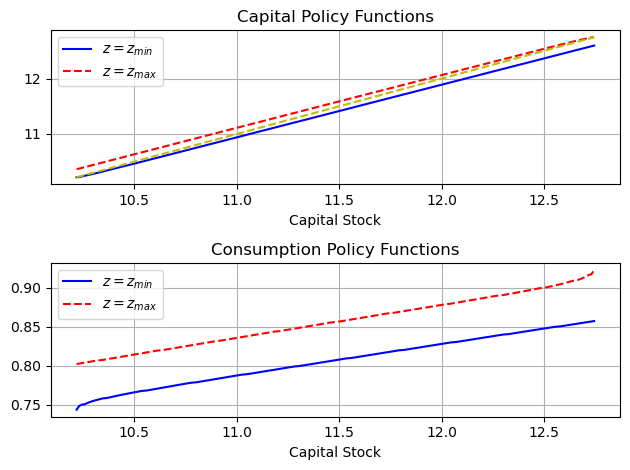

In [14]:
# Plot capital and consumption policy functions
fig2, axs2 = plt.subplots(2, 1)

axs2[0].plot(k, kpr[:,0], 'b', label = '$z=z_{min}$')
axs2[0].plot(k, kpr[:,-1], 'r--', label = '$z=z_{max}$')
axs2[0].plot(k, k, 'y--')
axs2[0].set(xlabel='Capital Stock', title='Capital Policy Functions')
axs2[0].grid()
axs2[0].legend()



axs2[1].plot(k, polc[:,0], 'b', label = '$z=z_{min}$')
axs2[1].plot(k, polc[:,-1], 'r--', label = '$z=z_{max}$')
axs2[1].set(xlabel='Capital Stock', title='Consumption Policy Functions')
axs2[1].grid()
axs2[1].legend()


plt.tight_layout()
plt.savefig('Hansen_CDP_policy.jpg', dpi=800)
plt.show()
plt.close(fig2)

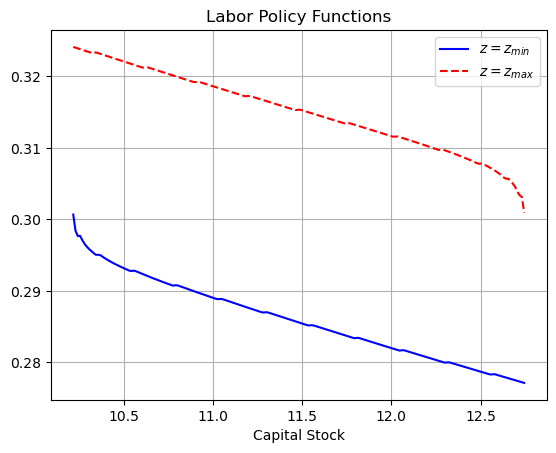

In [15]:
# Plot labor policy functions
fig3, ax3 = plt.subplots()
ax3.plot(k, lpol[:,0], 'b', label = '$z=z_{min}$')
ax3.plot(k, lpol[:,-1], 'r--', label = '$z=z_{max}$')

ax3.set(xlabel='Capital Stock', title='Labor Policy Functions')
ax3.grid()
ax3.legend()

fig3.savefig("Hansen_CDP_labor.jpg", dpi=800)
plt.show()

In [16]:
# Simulation

if lk < 10:
    siyes = 0


if siyes == 1:
    np.random.seed(0)
    
    T = 115  # simulation time period
    n = 100  # # of simulations
    
    tind = np.zeros((n,T+1),dtype=np.int8)
    kind = np.zeros((n,T+1),dtype=np.int8)
    ktime = np.zeros((n,T+1))
    zt = np.zeros((n,T+1))
    ltime = np.zeros((n,T))
    output = np.zeros((n,T))
    invest = np.zeros((n,T))
    cons = np.zeros((n,T))
    ss_mat = np.zeros((n,6))
    cc_mat = np.zeros((n,6))
    
    for m in np.arange(0,n):
        tind[m,0] = 4
        kind[m,0] = 34
        zt[m,0] = z[tind[m,0]]
        ktime[m,0]=k[kind[m,0]]
    
        for time in np.arange(0,T):
            ktime[m,time+1]=fminbound(func=simulation,x1=k[0],\
                                      x2=min(zt[m,time]*ktime[m,time]**alf+(1-delta)*ktime[m,time]-0.00001,k[lk-1]),\
                                        args=(k, beta, time, m, a, V0, Tran, tind, zt[m,time], alf, ktime[m,time], lmin, \
                                              lmax, delta,),xtol=1e-04)
            
            ltime[m,time] = l
            cons[m,time] = c
            invest[m,time] = ktime[m,time+1]-(1-delta)*ktime[m,time]
            output[m,time] = cons[m,time]+invest[m,time]
            
            shock = np.random.random()
            j = 0
            while Tran[tind[m,time],0:j+1].sum() < shock:
                j = j + 1

            tind[m,time+1] = j
            zt[m,time+1] = z[j]
            
            
        logy = np.log(output[m,0:T])[np.newaxis,:]
        logc = np.log(cons[m,0:T])[np.newaxis,:]
        loginv = np.log(invest[m,0:T])[np.newaxis,:]
        logk = np.log(ktime[m,0:T])[np.newaxis,:]
        logl = np.log(ltime[m,0:T])[np.newaxis,:]
        logz = np.log(zt[m,0:T])[np.newaxis,:]
        
        
        dhp, dtr = hp1(np.concatenate((logy.T, logc.T, loginv.T, logk.T, logl.T, logz.T),axis=1), 1600)
        ss_mat[m,:] = np.std(dhp,axis=0)*100
        Corr = np.corrcoef(dhp,rowvar=False)
        cc_mat[m,:] = Corr[:,0]
            

    stdv = np.mean(ss_mat,axis=0)
    stdv_stdv = np.std(ss_mat,axis=0)
    corr = np.mean(cc_mat,axis=0)
    corr_stdv = np.std(cc_mat,axis=0)
    
    
    print('HANSEN: std(x)/std(y) corr(x,y) for y, c, i, k, h, prod')
    print(np.concatenate((np.array([[1.36, 0.42, 4.24, 0.36, 0.7, 0.68]]).T/1.36, \
                          np.array([[1, 0.89, 0.99, 0.06, 0.98, 0.98]]).T),axis=1))
    print('std(x) std(x)/std(y)  stdv_stdv corr(x,y) corr_stdv for y, c, i, k, h, prod:')
    print(np.concatenate((stdv[:,np.newaxis], (stdv/stdv[0])[:,np.newaxis], stdv_stdv[:,np.newaxis],\
                          corr[:,np.newaxis], corr_stdv[:,np.newaxis]),axis=1))

HANSEN: std(x)/std(y) corr(x,y) for y, c, i, k, h, prod
[[1.     1.    ]
 [0.3088 0.89  ]
 [3.1176 0.99  ]
 [0.2647 0.06  ]
 [0.5147 0.98  ]
 [0.5    0.98  ]]
std(x) std(x)/std(y)  stdv_stdv corr(x,y) corr_stdv for y, c, i, k, h, prod:
[[1.3914 1.     0.2322 1.     0.    ]
 [0.4878 0.3506 0.0871 0.9145 0.0235]
 [4.1614 2.9909 0.6995 0.9894 0.0048]
 [0.3804 0.2734 0.0866 0.0714 0.0891]
 [0.675  0.4852 0.1125 0.9782 0.0093]
 [0.9593 0.6895 0.1595 0.9982 0.0016]]


In [17]:
#!jupyter nbconvert --to script Hansen_CDP.ipynb